# 1110c - 2d, MR 100, no HE

In [16]:
from adios2toolspy import SuperCell, Particles, Fields
from h5toolspy import getH5Grid, selectSubSpace
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline 
plt.rcParams['figure.figsize'] = [16, 8]

In [55]:
class DistFunc:
    def __init__(self, hist):
        self._hist = hist
        self._counts = hist[0]
        self._bins = hist[1][1:]
        #print(f'DistFunc: {sum(hist[0])} particles')
        
    def plot(self, ax=None, **kwargs):
        if not ax: ax = plt.gca()
            
        ax.plot(self.bins(), self._hist[0], **kwargs)
        ax.set_yscale('log')
        #ax.set_xlabel('$v^2$')
        ax.set_ylabel('count')
        
    def plot_fit(self, A, T, ax=None):
        if not ax: ax = plt.gca()
            
        ax.plot(self.bins(), A*np.exp(-self.bins()/T))

    def bins(self):
        return .5 * (self._hist[1][:-1] + self._hist[1][1:])
    
def make_DistFunc(path, species, patch):
    SC = SuperCell(path, patch, patches=numPatches, species=species, cellsPerPatch=cellsPerPatch)
    h = SC.histogramV(nbins, log=True, dim='s')
    return DistFunc(h)

class Domain:
    def __init__(self, L, gdims):
        self.L = np.asarray(L)
        self.gdims = np.asarray(gdims, dtype=int)
        self.dx = self.L / self.gdims
        self.corner = -.5 * self.L
        self.y = np.linspace(self.corner[1], self.corner[1] + self.L[1], self.gdims[1], endpoint=False)
        self.z = np.linspace(self.corner[2], self.corner[2] + self.L[2], self.gdims[2], endpoint=False)
        
    def set_selection(self, start, count):
        self.start = np.asarray(start)
        self.count = np.asarray(count)
        self.yy = self.y[start[1]:start[1]+count[1]]
        self.zz = self.z[start[2]:start[2]+count[2]]
        
def plot_fld(domain, fld, downscale=0, ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
        
    ax.set_xlabel('y')
    ax.set_ylabel('z')
    y, z, f = domain.yy, domain.zz, fld
    for i in range(downscale):
        y = .5*(y[:-1:2] + y[1::2])
        z = .5*(z[:-1:2] + z[1::2])
        #f = .25*(f[:-1:2,:-1:2] + f[1::2,:-1:2] + f[:-1:2,1::2] + f[1::2,1::2])
    ax.set_aspect('equal')
    return ax.pcolormesh(y, z, f, shading='gouraud', **kwargs)

def plot_boxes(domain, patches):
    for patch in patches:
        selectSubSpace(domain.corner[1] + patch[1] * domain.dx[1],
                       domain.corner[2] + patch[2] * domain.dx[2],
                       numPatches=numPatches,
                       cellsPerPatch=domain.dx[1]*cellsPerPatch)

class Reader:
    def __init__(self, domain, root, what, time):
        self._domain = domain
        self._root = root
        self._what = what
        self._time = time
        
    def read(self, fldname, downscale=0):
        f = getH5Grid(self._root, self._what, fldname, self._time,
                         corner=domain.start, dims=domain.count)[:,:,0]
        for i in range(downscale):
            f = .25*(f[:-1:2,:-1:2] + f[1::2,:-1:2] + f[:-1:2,1::2] + f[1::2,1::2])

        return f



In [29]:
root = '/gpfs/alpine/proj-shared/fus137/kaig1/flatfoil-20201111a/'

domain = Domain([1, 2*800, 2*3*800], [1, 2*2*800, 2*2*3*800])
domain.set_selection(start=[0, 0, 2*2400], count=[1, 2*1600, 2*1200])

numPatches=1
cellsPerPatch=32
time = -1
times = [100000]
nbins = 100
specs = {'e': 'electron'}#, 'he': 'electron_he'}

In [30]:
nrows = 4
ncols = 5

rect = np.array([0, -800 + 384, 576])
patches = []
for j in range(nrows):
    for i in range(ncols):
        patch = rect + (0, 64 * i, 64 * j)
        b = ((patch - domain.corner) / domain.dx + .5).astype(int)
        b[0] = 0 # FIXME
        patches.append(b)


In [31]:
pfd, pfdm = Reader(domain, root, 'pfd', time), Reader(domain, root, 'pfd_moments', time)
bx = pfd.read('hx_fc')
n_e = -pfdm.read('rho_e')
txx_e, tyy_e, tzz_e = [pfdm.read(fld) for fld in ('txx_e', 'tyy_e', 'tzz_e')]
t_e = (1/3) * (txx_e + tyy_e + tzz_e) / n_e

n_he = -pfdm.read('rho_he_e')

bx.shape

Loading hx_fc from File: pfd.118000.xdmf
Loading rho_e from File: pfd_moments.118000.xdmf
Loading txx_e from File: pfd_moments.118000.xdmf
Loading tyy_e from File: pfd_moments.118000.xdmf
Loading tzz_e from File: pfd_moments.118000.xdmf
Loading rho_he_e from File: pfd_moments.118000.xdmf


/ccs/home/kaig1/.conda/envs/psc/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


(2400, 3200)

/ccs/home/kaig1/.conda/envs/psc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


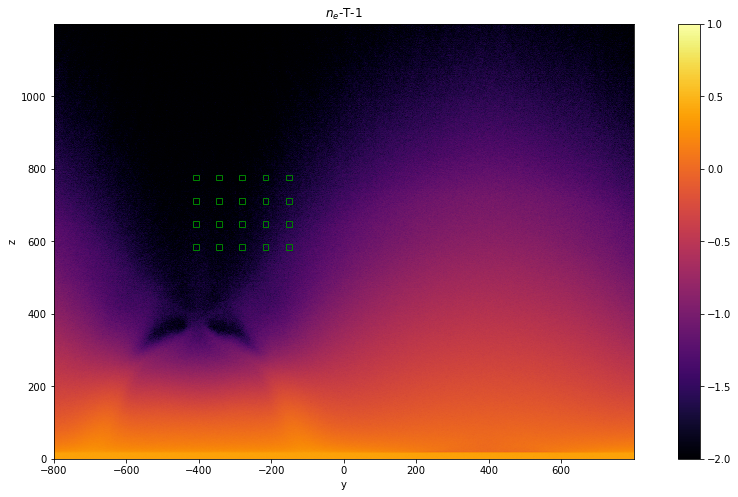

In [10]:
plt.title(f'$n_e$-T{time}')
plot_fld(domain, np.log10(n_e), cmap='inferno')
plt.clim(-2, 1)
plt.colorbar()
plot_boxes(domain, patches)

/ccs/home/kaig1/.conda/envs/psc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


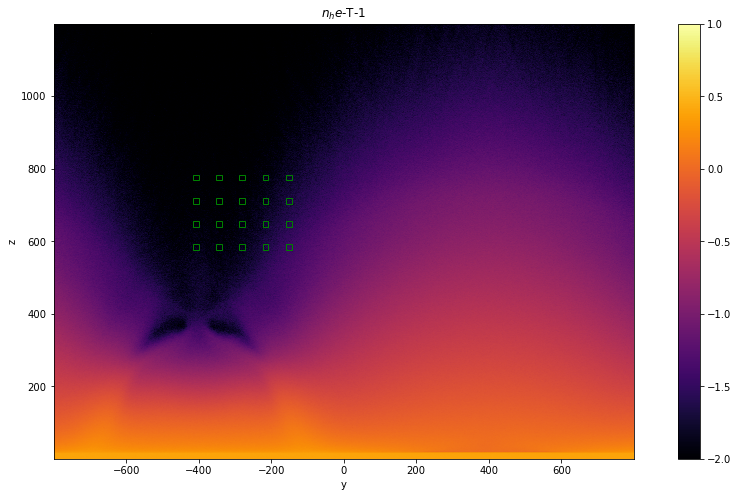

In [9]:
plt.title(f'$n_he$-T{time}')
plot_fld(domain, np.log10(n_e), downscale=1, cmap='inferno')
plt.clim(-2, 1)
plt.colorbar()
plot_boxes(domain, patches)

/ccs/home/kaig1/.conda/envs/psc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


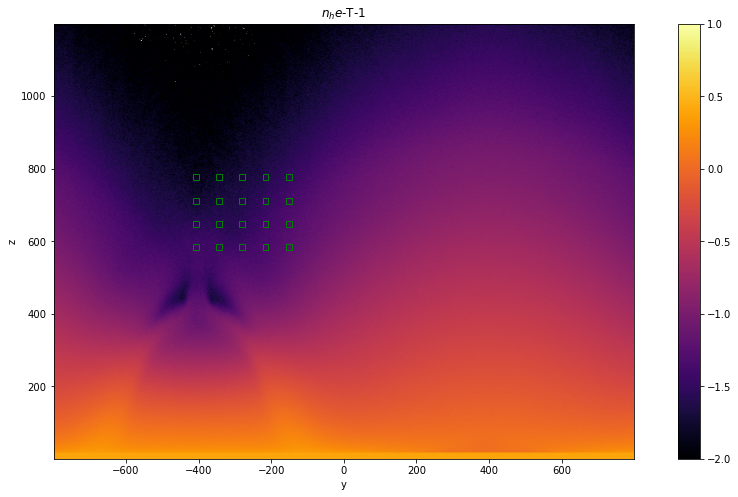

In [21]:
plt.title(f'$n_he$-T{time}')
plot_fld(domain, np.log10(n_e), downscale=2, cmap='inferno')
plt.clim(-2, 1)
plt.colorbar()
plot_boxes(domain, patches)

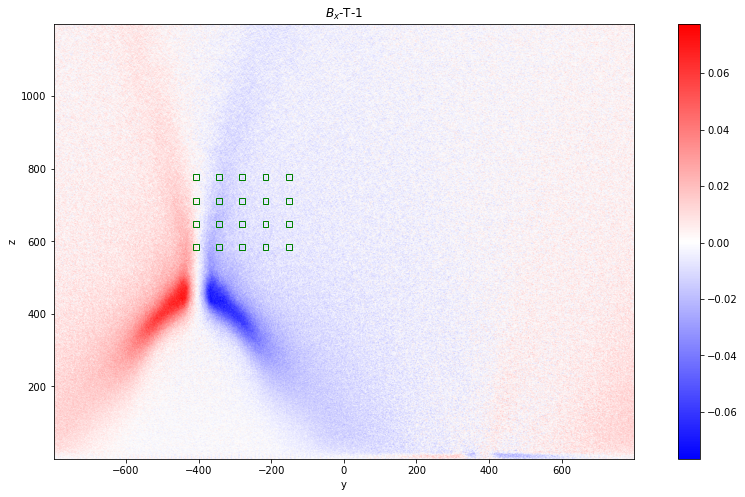

In [22]:
plt.title(f'$B_x$-T{time}')
plot_fld(domain, bx, downscale=2, cmap='bwr')
plt.colorbar()
plot_boxes(domain, patches)

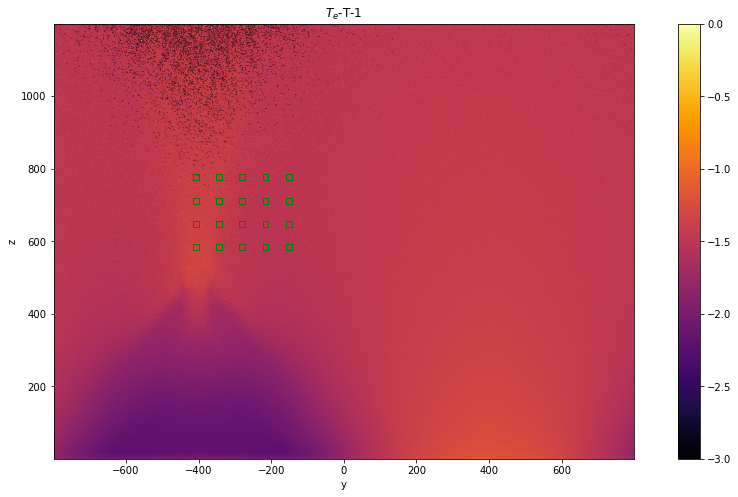

In [23]:
plt.title(f'$T_e$-T{time}')
plot_fld(domain, np.log10(t_e), downscale=2, cmap='inferno')
#plot_fld(domain, t_e, cmap='inferno')
plt.clim(-3, 0)
plt.colorbar()
plot_boxes(domain, patches)


In [24]:
dfs = {}
for s, species in specs.items():
    d = []
    for t in times:
        path = os.path.join(root, f'checkpoint_{t}.bp')
        d.append([make_DistFunc(path, species, patch) for patch in patches])

    dfs[s] = d

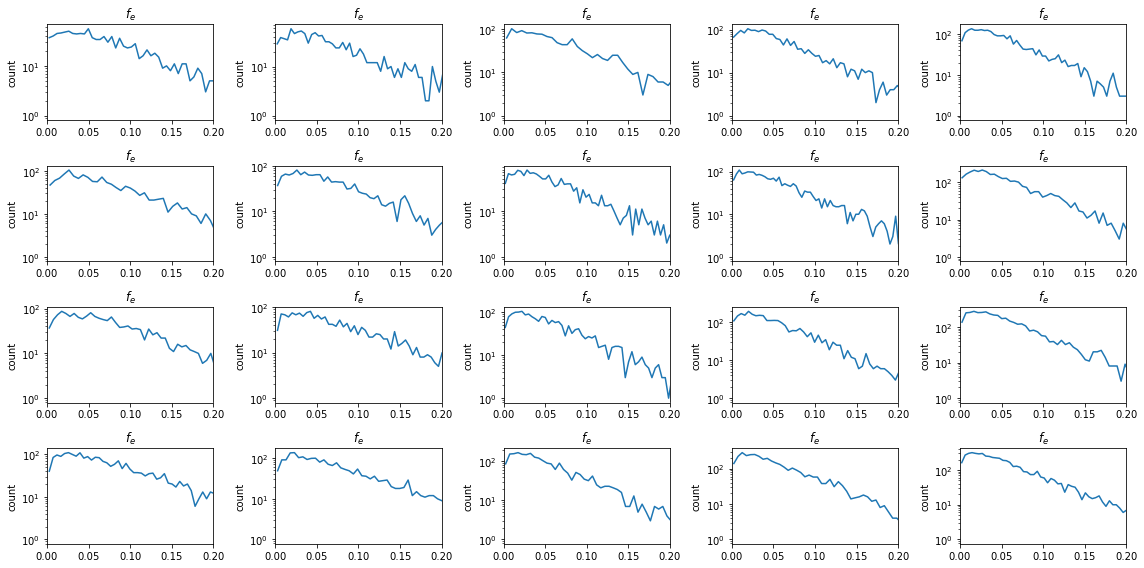

In [25]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
t = 0
for j in range(nrows):
    for i in range(ncols):
        ax = axes[j, i]
        idx = (nrows - j - 1) * ncols + i
        dfs['e'][t][idx].plot(ax=ax)
        ax.set_title('$f_e$')
        #ax.set_ylim(.5, 1e3)
        ax.set_xlim(0, .2)
plt.tight_layout()

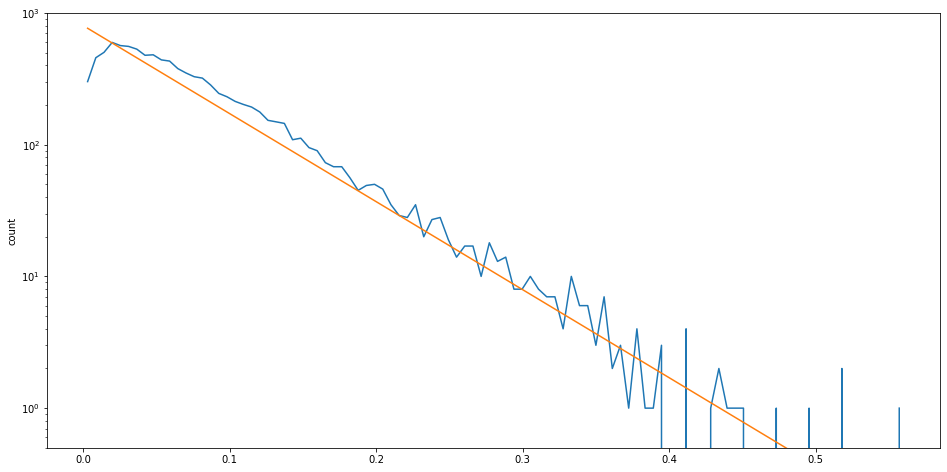

In [17]:
df = dfs['e'][0][3*ncols+0]
df.plot()
df.plot_fit(8e2, .065)
plt.ylim(.5, 1e3);

In [110]:
ftimes = range(20, 100, 20)
flds = ['$n_e$', '$T_e$', '$B_x$']
#flds = ['$n_HE$', '$T_HE$', '$B_x$']
ds = 3

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

def make_plots(ftimes, flds, ds):
    fig, axes = plt.subplots(ncols=len(ftimes), nrows=len(flds))
    for j, t in enumerate(ftimes):
        pfd = Reader(domain, root, 'pfd', t)
        pfdm = Reader(domain, root, 'pfd_moments', t)
        for i, fld in enumerate(flds):
            ax = axes[i,j]
            ax.set_title(fld)
            cmap = 'inferno'
            if fld == '$n_e$':
                f = -pfdm.read('rho_e', downscale=ds)
                norm = colors.LogNorm(1e-2, np.max(f))
            if fld == '$n_HE$':
                f = -pfdm.read('rho_he_e', downscale=ds)
                norm = colors.LogNorm(1e-4, np.max(f))
            elif fld == '$T_e$':
                n_e = -pfdm.read('rho_e', downscale=ds)
                txx_e, tyy_e, tzz_e = [pfdm.read(fld, downscale=ds) for fld in ('txx_e', 'tyy_e', 'tzz_e')]
                f = (1/3) * (txx_e + tyy_e + tzz_e) / n_e
                max = np.nan_to_num(np.max(f), nan=1)
                norm = colors.LogNorm(5e-3, max)
            elif fld == '$T_HE$':
                n_e = -pfdm.read('rho_he_e', downscale=ds)
                txx_e, tyy_e, tzz_e = [pfdm.read(fld, downscale=ds) for fld in ('txx_he_e', 'tyy_he_e', 'tzz_he_e')]
                f = (1/3) * (txx_e + tyy_e + tzz_e) / n_e
                max = np.nan_to_num(np.max(f), nan=1)
                norm = colors.LogNorm(2e-3, max)
            elif fld == '$B_x$':
                f = pfd.read('hx_fc', downscale=ds)
                max = np.max(f)
                norm = colors.Normalize(-max, max)
                cmap = 'bwr'

            m = plot_fld(domain, f, downscale=ds, ax=ax, norm=norm, cmap=cmap)

            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(m, cax=cax, orientation='vertical')

    plt.tight_layout()

    #plot_boxes(domain, patches)


Loading rho_e from File: pfd_moments.040000.xdmf
Loading rho_e from File: pfd_moments.040000.xdmf
Loading txx_e from File: pfd_moments.040000.xdmf
Loading tyy_e from File: pfd_moments.040000.xdmf
Loading tzz_e from File: pfd_moments.040000.xdmf
Loading hx_fc from File: pfd.040000.xdmf


/ccs/home/kaig1/.conda/envs/psc/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Loading rho_e from File: pfd_moments.080000.xdmf
Loading rho_e from File: pfd_moments.080000.xdmf
Loading txx_e from File: pfd_moments.080000.xdmf
Loading tyy_e from File: pfd_moments.080000.xdmf
Loading tzz_e from File: pfd_moments.080000.xdmf
Loading hx_fc from File: pfd.080000.xdmf
Loading rho_e from File: pfd_moments.120000.xdmf
Loading rho_e from File: pfd_moments.120000.xdmf
Loading txx_e from File: pfd_moments.120000.xdmf
Loading tyy_e from File: pfd_moments.120000.xdmf
Loading tzz_e from File: pfd_moments.120000.xdmf
Loading hx_fc from File: pfd.120000.xdmf
Loading rho_e from File: pfd_moments.160000.xdmf
Loading rho_e from File: pfd_moments.160000.xdmf
Loading txx_e from File: pfd_moments.160000.xdmf
Loading tyy_e from File: pfd_moments.160000.xdmf
Loading tzz_e from File: pfd_moments.160000.xdmf
Loading hx_fc from File: pfd.160000.xdmf


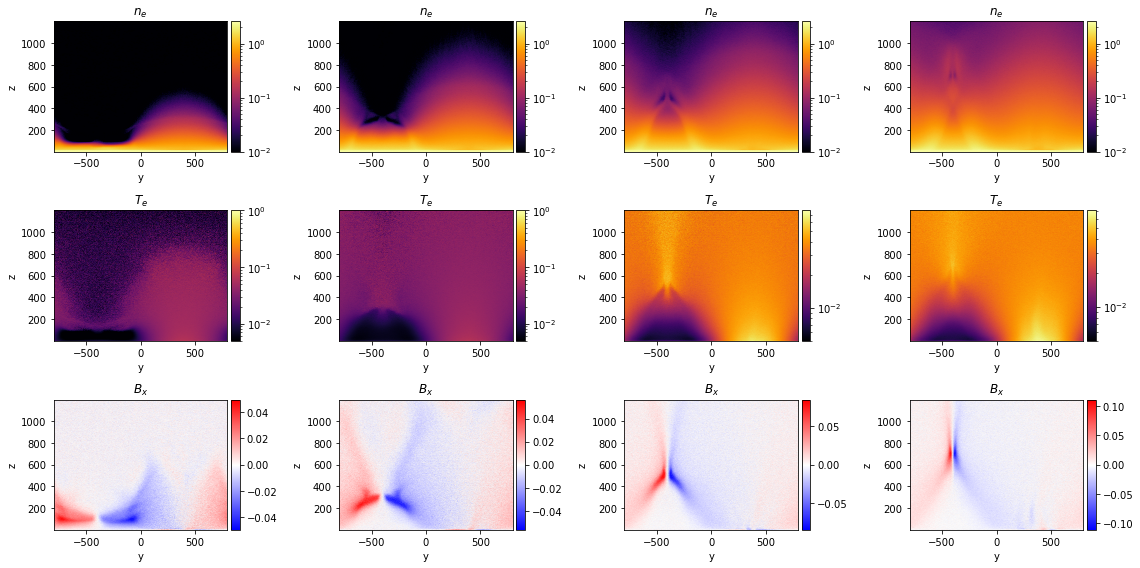

In [106]:
make_plots(range(20, 100, 20), ['$n_e$', '$T_e$', '$B_x$'], 2)

Loading rho_he_e from File: pfd_moments.040000.xdmf
Loading rho_he_e from File: pfd_moments.040000.xdmf
Loading txx_he_e from File: pfd_moments.040000.xdmf
Loading tyy_he_e from File: pfd_moments.040000.xdmf
Loading tzz_he_e from File: pfd_moments.040000.xdmf
Loading hx_fc from File: pfd.040000.xdmf
Loading rho_he_e from File: pfd_moments.080000.xdmf


/ccs/home/kaig1/.conda/envs/psc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


Loading rho_he_e from File: pfd_moments.080000.xdmf
Loading txx_he_e from File: pfd_moments.080000.xdmf
Loading tyy_he_e from File: pfd_moments.080000.xdmf
Loading tzz_he_e from File: pfd_moments.080000.xdmf
Loading hx_fc from File: pfd.080000.xdmf
Loading rho_he_e from File: pfd_moments.120000.xdmf
Loading rho_he_e from File: pfd_moments.120000.xdmf
Loading txx_he_e from File: pfd_moments.120000.xdmf
Loading tyy_he_e from File: pfd_moments.120000.xdmf
Loading tzz_he_e from File: pfd_moments.120000.xdmf
Loading hx_fc from File: pfd.120000.xdmf
Loading rho_he_e from File: pfd_moments.160000.xdmf
Loading rho_he_e from File: pfd_moments.160000.xdmf
Loading txx_he_e from File: pfd_moments.160000.xdmf
Loading tyy_he_e from File: pfd_moments.160000.xdmf
Loading tzz_he_e from File: pfd_moments.160000.xdmf
Loading hx_fc from File: pfd.160000.xdmf


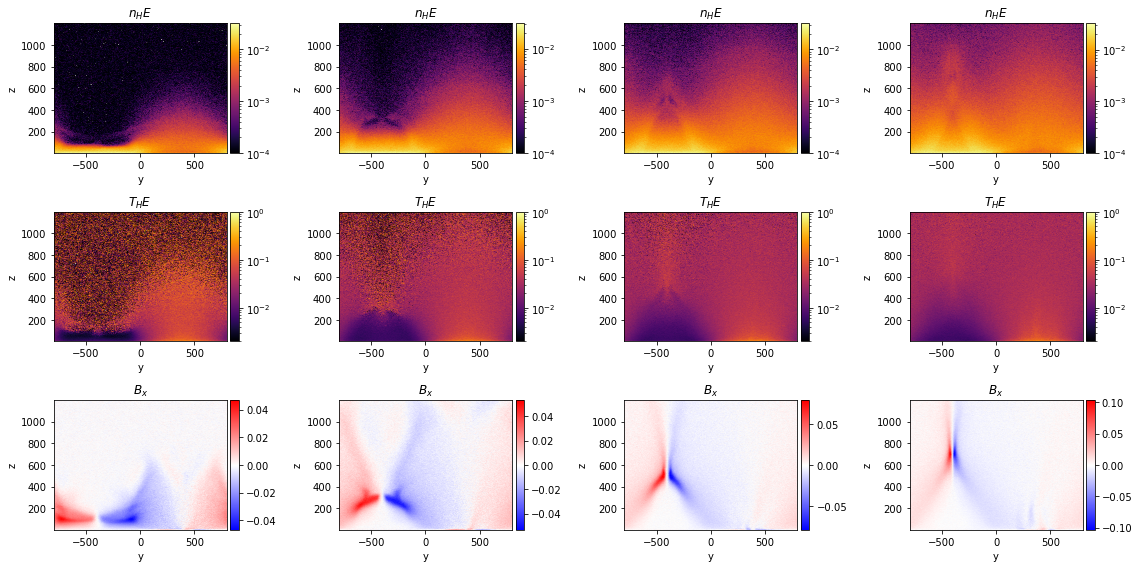

In [111]:
make_plots(range(20, 100, 20), ['$n_HE$', '$T_HE$', '$B_x$'], 3)